In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

plt.style.use('seaborn-darkgrid')

In [2]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [3]:
JobsDF = pd.read_csv('COVID_Jobs_Merged.csv', index_col = 0)
JobsDF.head()

,State,cases,deaths,All Occupations 2018,Computer Mathematical Scientists 2018,Computer Mathematical Scientists 2018 (Percent),Engineers 2018,Engineers 2018 (Percent),Life Scientists 2018,Life Scientists 2018 (Percent),Physical Scientists 2018,Physical Scientists 2018 (Percent),Science Engineer Workers 2018,Science Engineer Workers 2018 (Percent),Social Scientists 2018,Social Scientists 2018 (Percent),Technical Workers 2018,Technical Workers 2018 (Percent)
0,Alabama,387786,14345,1943760.0,34810.0,1.790859,32340.0,1.663786,3180.0,0.163600,2780.0,NaN,69821.428571,3.727577,3195.000000,0.170005,25768.461538,1.377782
1,Alaska,18316,367,315250.0,4820.0,1.528945,5060.0,1.605075,1830.0,0.580492,1670.0,NaN,14480.000000,4.593180,1090.000000,0.345757,6370.000000,2.020619
2,Arizona,426614,18857,2789520.0,92170.0,3.304153,35180.0,1.261149,4480.0,0.160601,4174.0,NaN,114216.428571,4.532470,7870.000000,0.282127,40286.923077,1.608712
3,Arkansas,161569,3301,1210120.0,21960.0,1.814696,8190.0,0.676792,2210.0,0.182627,1462.0,NaN,35500.000000,2.933593,2426.923077,0.209530,11790.000000,0.974284
4,California,2664110,102387,17007690.0,592510.0,3.483777,243550.0,1.431999,63800.0,0.375124,39360.0,NaN,989560.000000,5.818309,50350.000000,0.296043,266500.000000,1.566938


In [4]:
JobsDF.drop([col for col in JobsDF.columns if '(Percent)' in col], axis = 1, inplace = True)
JobsDF = JobsDF.drop(columns = ['cases', 'deaths'])
JobsDF.head()

,State,All Occupations 2018,Computer Mathematical Scientists 2018,Engineers 2018,Life Scientists 2018,Physical Scientists 2018,Science Engineer Workers 2018,Social Scientists 2018,Technical Workers 2018
0,Alabama,1943760.0,34810.0,32340.0,3180.0,2780.0,69821.428571,3195.000000,25768.461538
1,Alaska,315250.0,4820.0,5060.0,1830.0,1670.0,14480.000000,1090.000000,6370.000000
2,Arizona,2789520.0,92170.0,35180.0,4480.0,4174.0,114216.428571,7870.000000,40286.923077
3,Arkansas,1210120.0,21960.0,8190.0,2210.0,1462.0,35500.000000,2426.923077,11790.000000
4,California,17007690.0,592510.0,243550.0,63800.0,39360.0,989560.000000,50350.000000,266500.000000


In [5]:
JobsDF = JobsDF.round({'Science Engineer Workers 2018':1,
                      'Social Scientists 2018':1,
                      'Technical Workers 2018':1})
JobsDF.head()

,State,All Occupations 2018,Computer Mathematical Scientists 2018,Engineers 2018,Life Scientists 2018,Physical Scientists 2018,Science Engineer Workers 2018,Social Scientists 2018,Technical Workers 2018
0,Alabama,1943760.0,34810.0,32340.0,3180.0,2780.0,69821.4,3195.0,25768.5
1,Alaska,315250.0,4820.0,5060.0,1830.0,1670.0,14480.0,1090.0,6370.0
2,Arizona,2789520.0,92170.0,35180.0,4480.0,4174.0,114216.4,7870.0,40286.9
3,Arkansas,1210120.0,21960.0,8190.0,2210.0,1462.0,35500.0,2426.9,11790.0
4,California,17007690.0,592510.0,243550.0,63800.0,39360.0,989560.0,50350.0,266500.0


In [6]:
COVID_Case = pd.read_csv('COVID.csv', index_col = 0)
COVID_Case.head()

,State,cases,deaths
0,Alabama,26912,785
1,Alaska,751,10
2,Arizona,39298,1228
3,Arkansas,13191,188
4,California,159098,5202


In [7]:
JobsDF = pd.merge(JobsDF, COVID_Case, how = 'left', on = 'State')
JobsDF.head()

,State,All Occupations 2018,Computer Mathematical Scientists 2018,Engineers 2018,Life Scientists 2018,Physical Scientists 2018,Science Engineer Workers 2018,Social Scientists 2018,Technical Workers 2018,cases,deaths
0,Alabama,1943760.0,34810.0,32340.0,3180.0,2780.0,69821.4,3195.0,25768.5,26912,785
1,Alaska,315250.0,4820.0,5060.0,1830.0,1670.0,14480.0,1090.0,6370.0,751,10
2,Arizona,2789520.0,92170.0,35180.0,4480.0,4174.0,114216.4,7870.0,40286.9,39298,1228
3,Arkansas,1210120.0,21960.0,8190.0,2210.0,1462.0,35500.0,2426.9,11790.0,13191,188
4,California,17007690.0,592510.0,243550.0,63800.0,39360.0,989560.0,50350.0,266500.0,159098,5202


In [8]:
df=JobsDF
test_len = int(0.25 * len(df))
train_len = len(df) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = df[:train_len]
test = df[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 11)
Test Set Shape: (12, 11)


In [9]:
features_list = ['Computer Mathematical Scientists 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 23476.2154928935
Train MSE Value: 2969773825.13968
Train RMS Value: 54495.631248198966
Train R2 Score: 0.38638764039461626


Test MAE Value: 11510.949349166121
Test MSE Value: 239700451.15254188
Test RMS Value: 15482.262468791241
Test R2 Score: 0.650495959385243


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


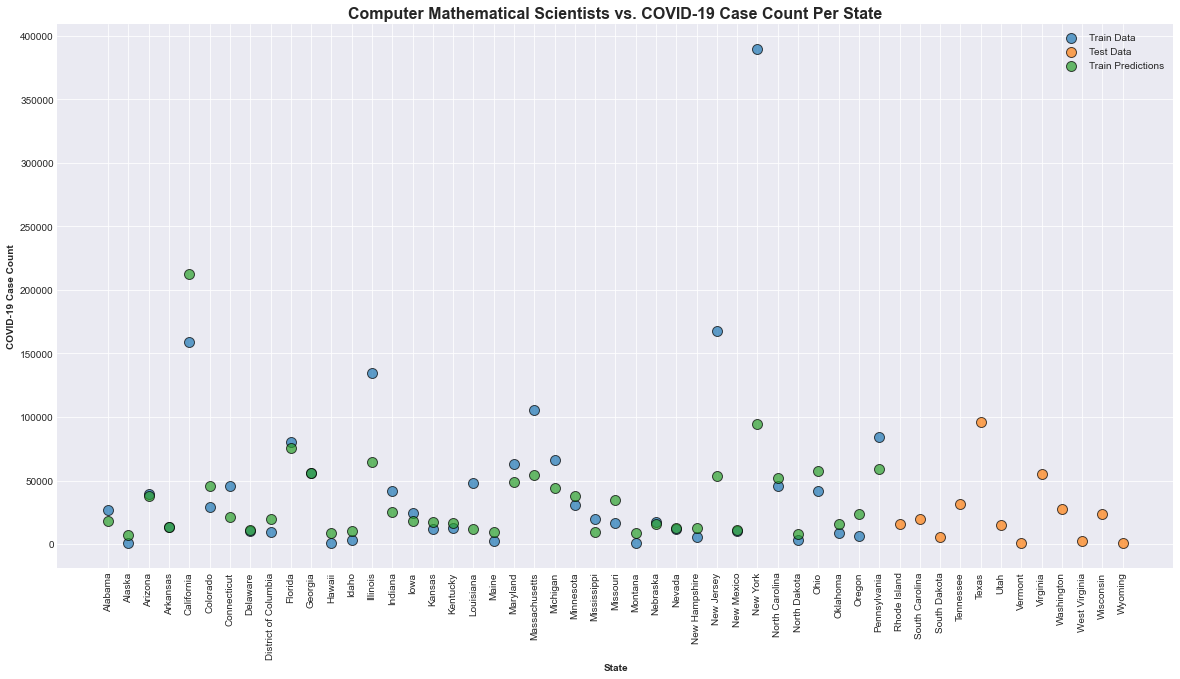

In [10]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Computer Mathematical Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


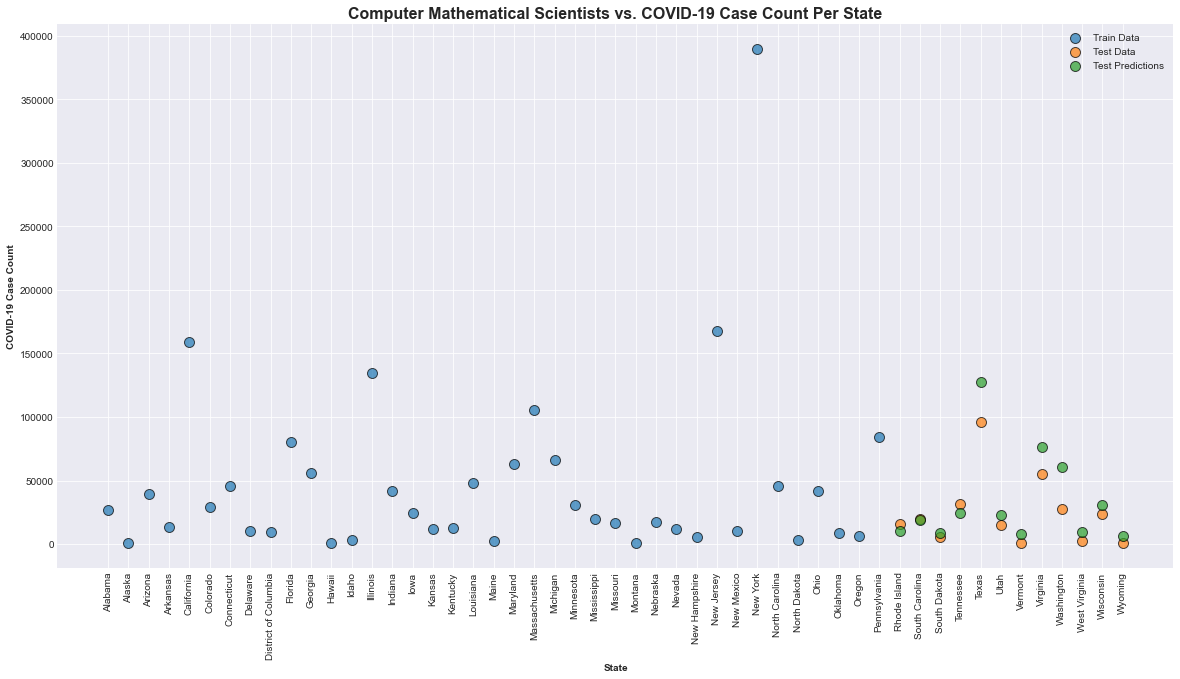

In [11]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Computer Mathematical Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [12]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6602 degrees.
Accuracy = 80.72%.


80.7231060203602

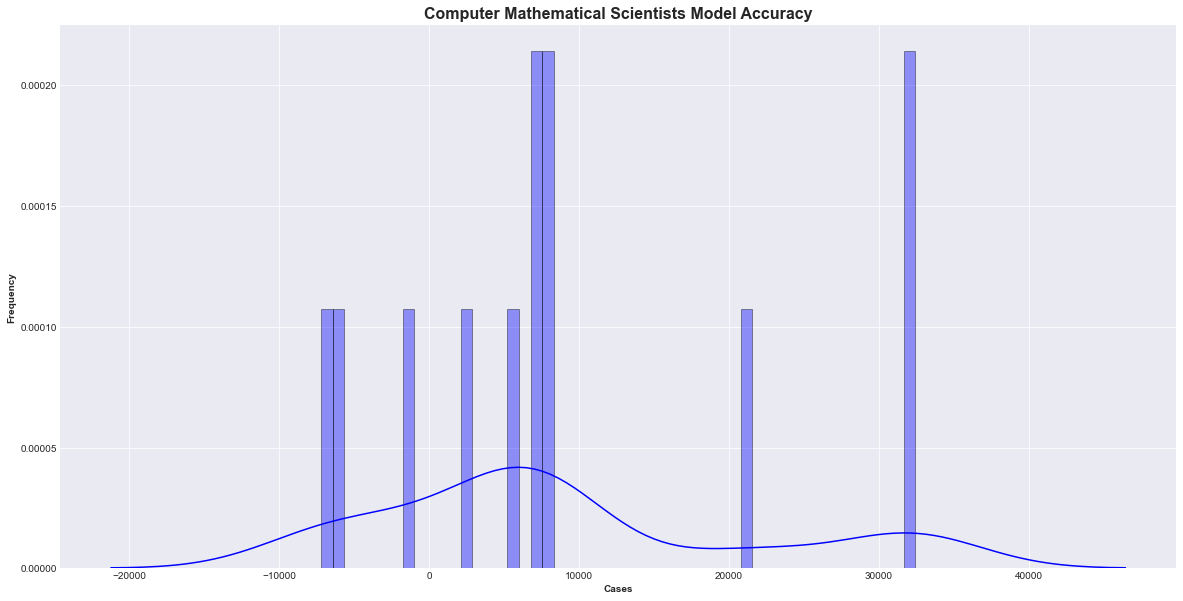

In [13]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Computer Mathematical Scientists Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [14]:
features_list = ['Engineers 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 25554.767062183055
Train MSE Value: 3745120997.463803
Train RMS Value: 61197.393714633
Train R2 Score: 0.22618601025842555


Test MAE Value: 9028.659715299851
Test MSE Value: 104912380.43776657
Test RMS Value: 10242.67447680373
Test R2 Score: 0.8470286530659157


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


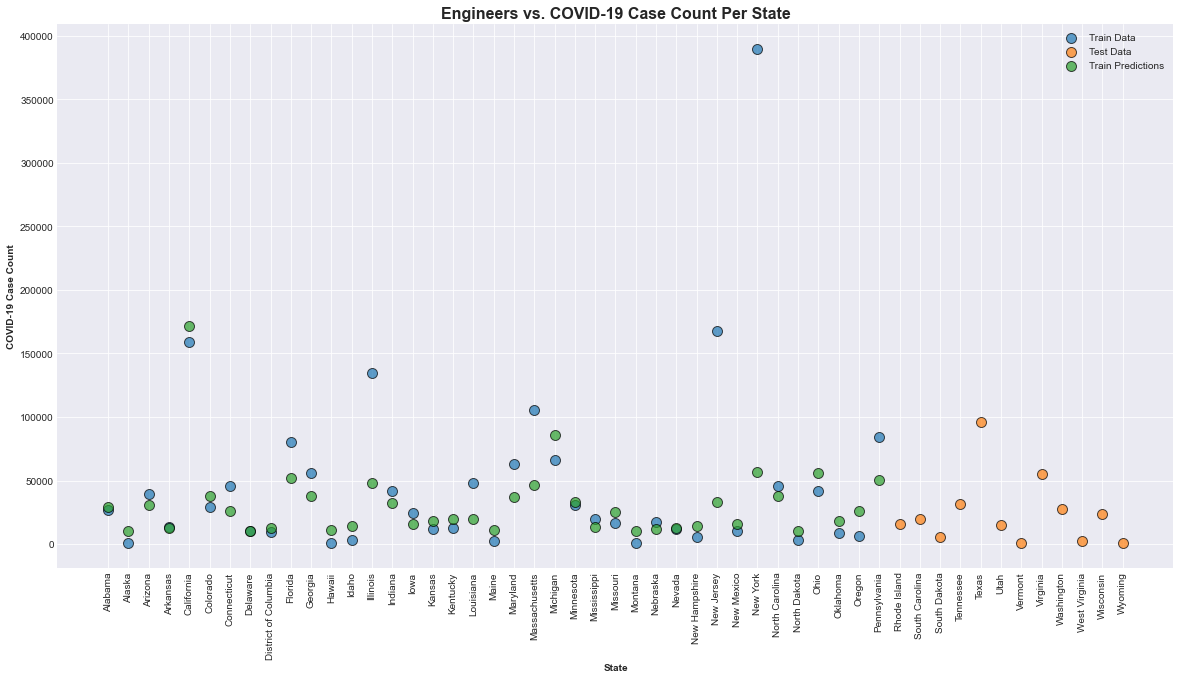

In [15]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Engineers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


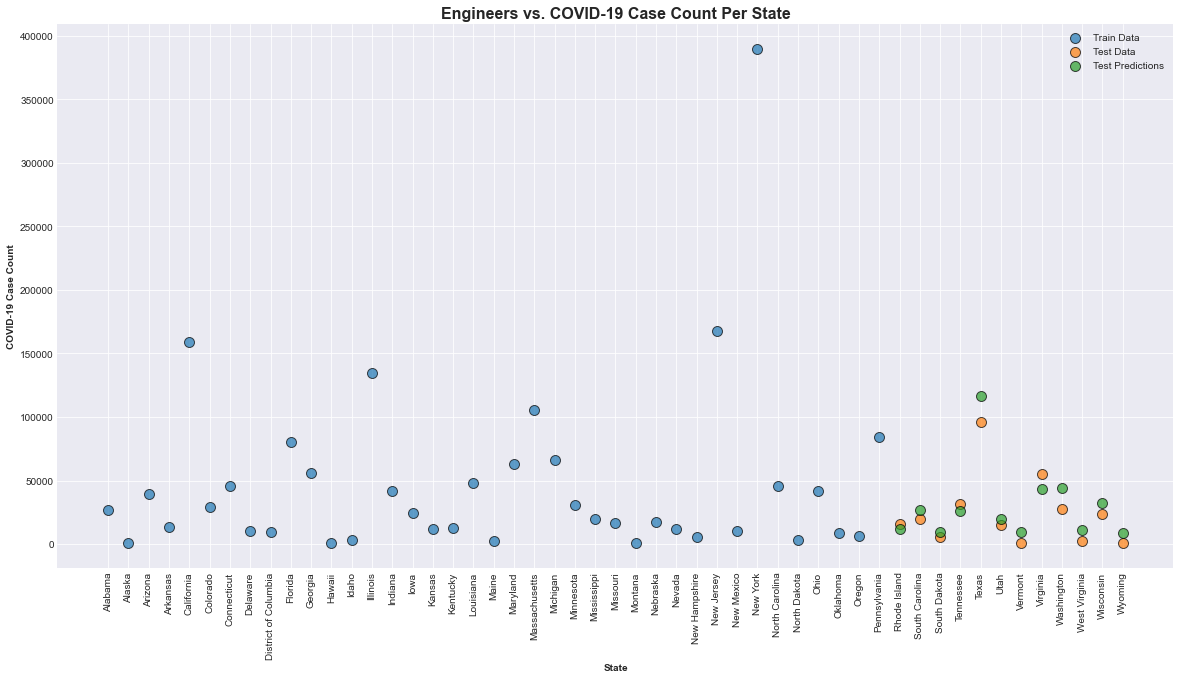

In [16]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Engineers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [17]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6212 degrees.
Accuracy = 70.15%.


70.14684830661395

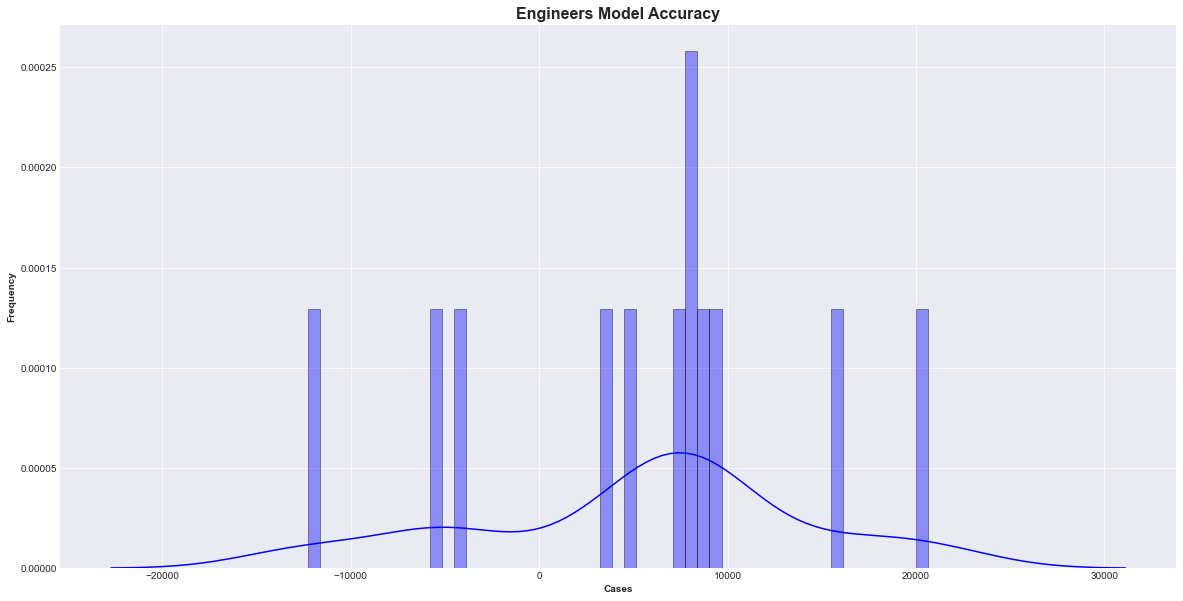

In [18]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Engineers Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [19]:
features_list = ['Life Scientists 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 25342.918352299093
Train MSE Value: 3272852997.5515666
Train RMS Value: 57208.854188417085
Train R2 Score: 0.32376565734775653


Test MAE Value: 10647.959768491763
Test MSE Value: 192329395.72433078
Test RMS Value: 13868.287411368816
Test R2 Score: 0.7195670654292159


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


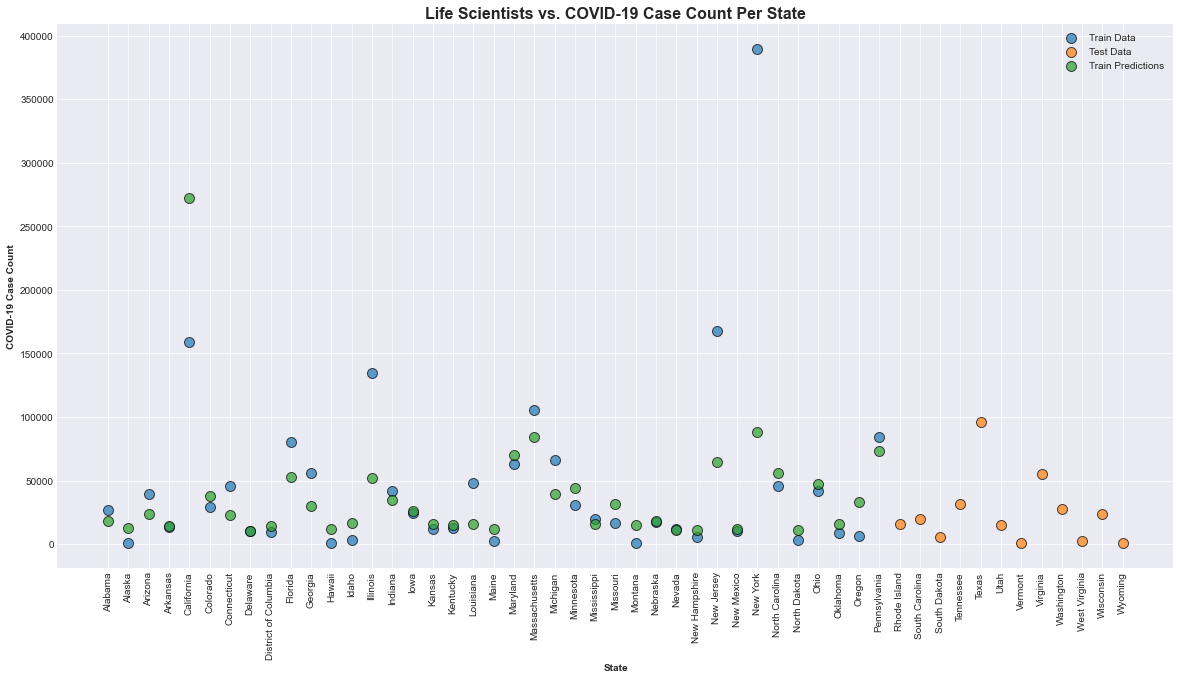

In [20]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Life Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


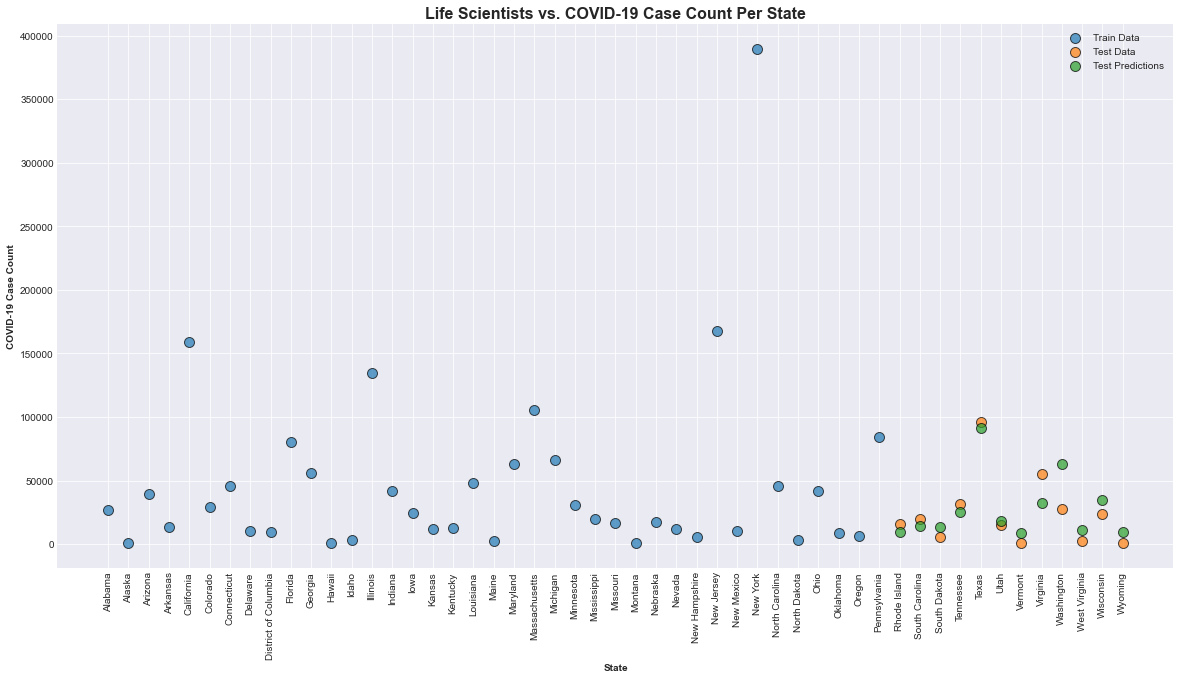

In [21]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Life Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [22]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6791 degrees.
Accuracy = 79.81%.


79.8057198811627

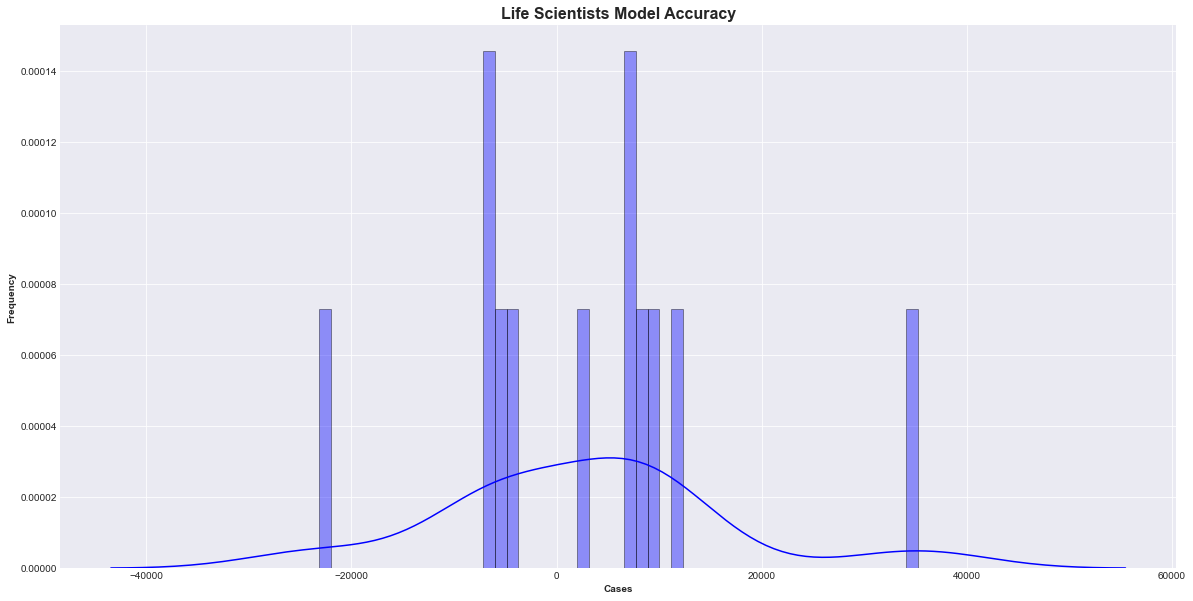

In [23]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Life Scientists Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [24]:
features_list = ['Physical Scientists 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 24868.251354825155
Train MSE Value: 2930934855.3710184
Train RMS Value: 54138.10908566182
Train R2 Score: 0.394412518142089


Test MAE Value: 10096.602408487337
Test MSE Value: 282216660.5301476
Test RMS Value: 16799.305358560145
Test R2 Score: 0.5885036398145141


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


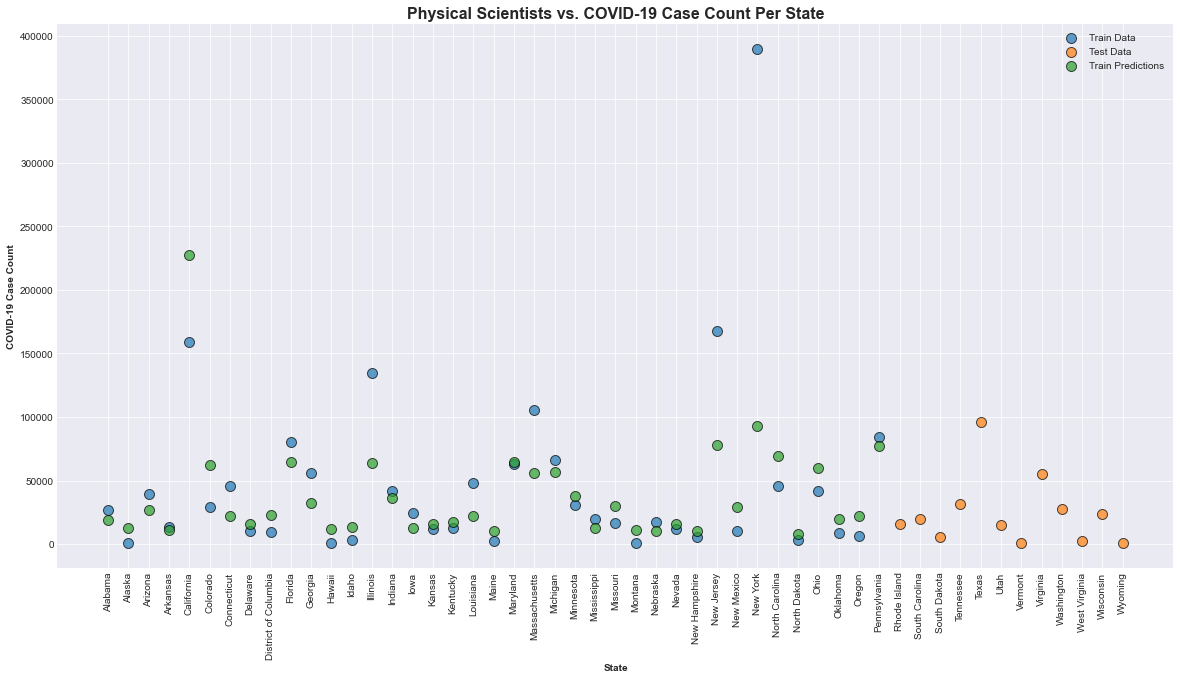

In [25]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Physical Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


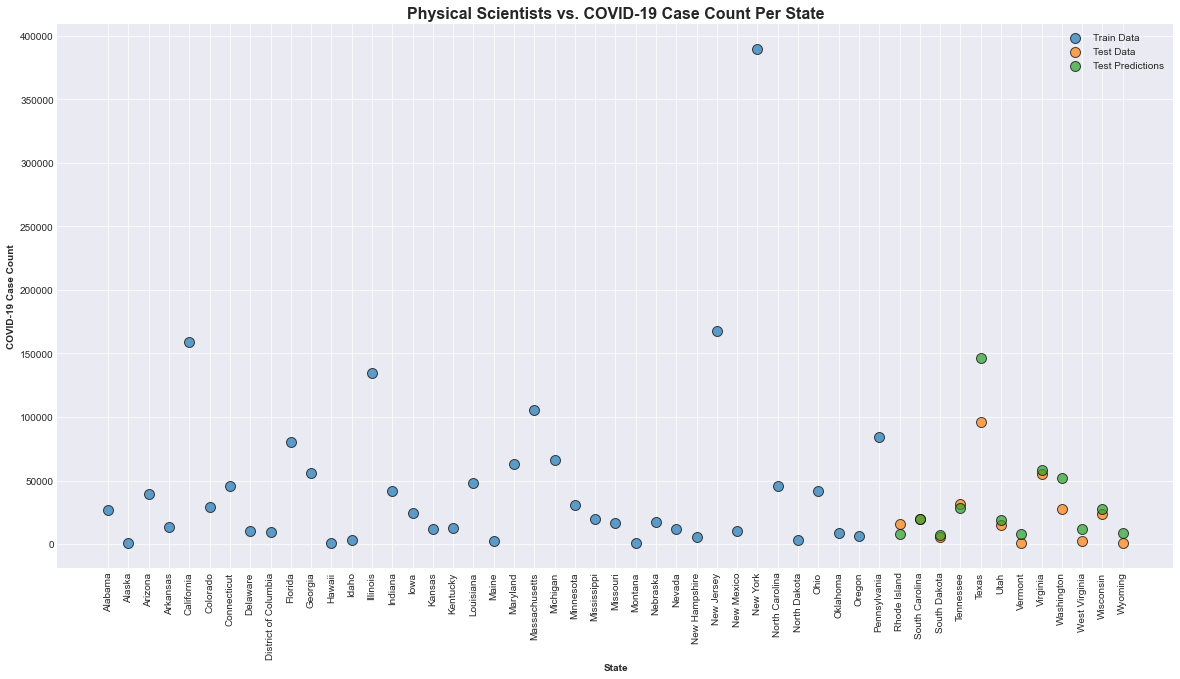

In [26]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Physical Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [27]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6777 degrees.
Accuracy = 85.06%.


85.06211191260007

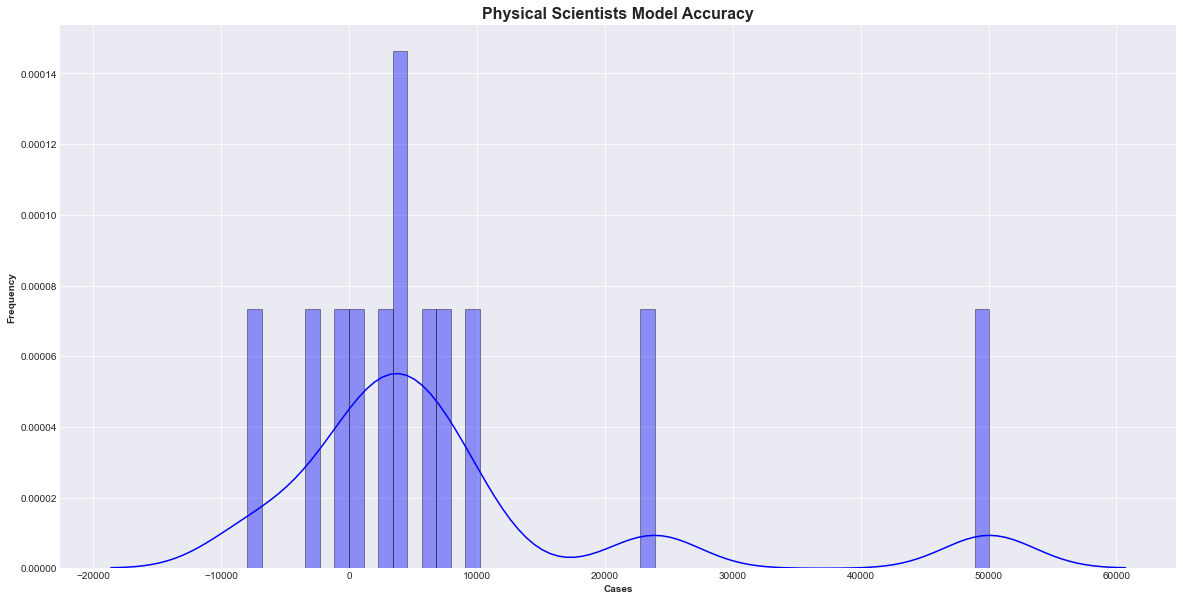

In [28]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Physical Scientists Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [29]:
features_list = ['Science Engineer Workers 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 23740.27371228107
Train MSE Value: 2994810102.046187
Train RMS Value: 54724.8581729198
Train R2 Score: 0.3812146643186981


Test MAE Value: 10936.594603793383
Test MSE Value: 254398751.65384138
Test RMS Value: 15949.8824965528
Test R2 Score: 0.6290645628623182


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


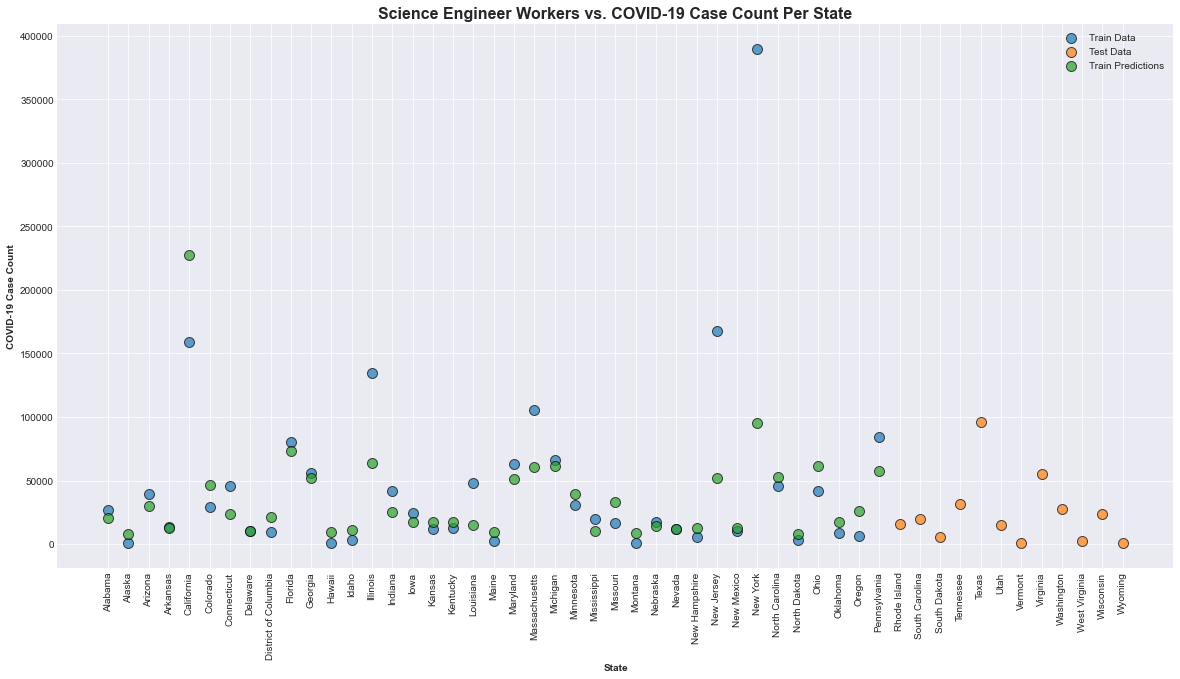

In [30]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Science Engineer Workers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


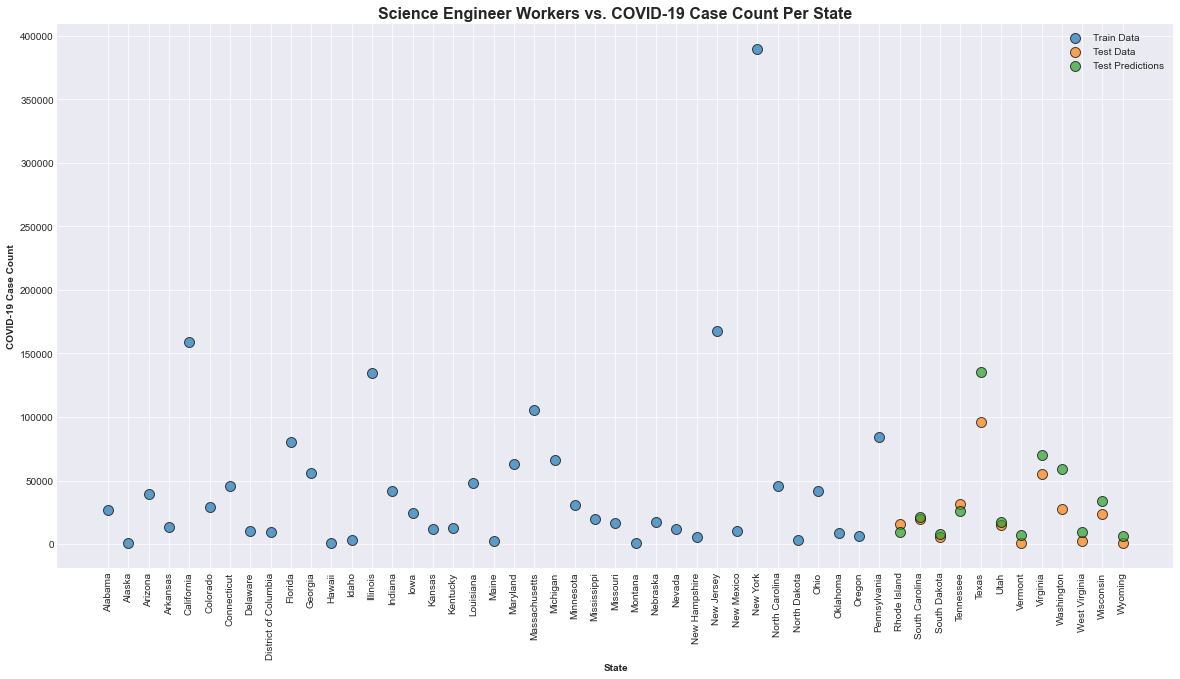

In [31]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Science Engineer Workers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [32]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6684 degrees.
Accuracy = 82.60%.


82.60343134846363

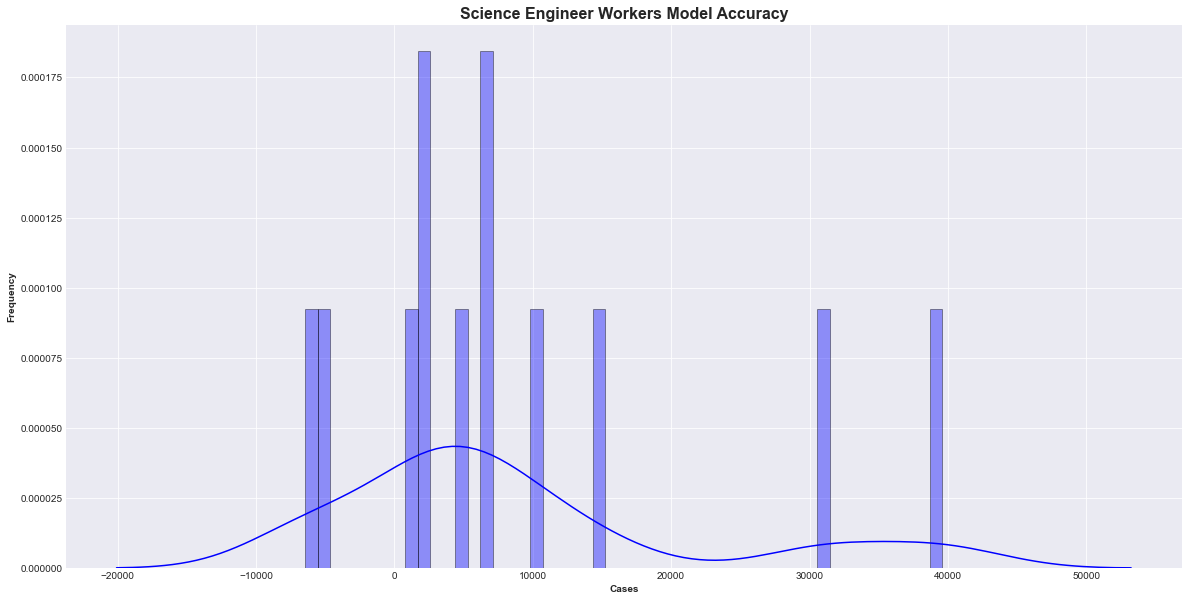

In [33]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Science Engineer Workers Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [34]:
features_list = ['Social Scientists 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 22444.73095113452
Train MSE Value: 2109826054.9105916
Train RMS Value: 45932.84287860476
Train R2 Score: 0.5640693803172989


Test MAE Value: 9122.794189182217
Test MSE Value: 124245878.03482313
Test RMS Value: 11146.563507863002
Test R2 Score: 0.8188387372902177


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


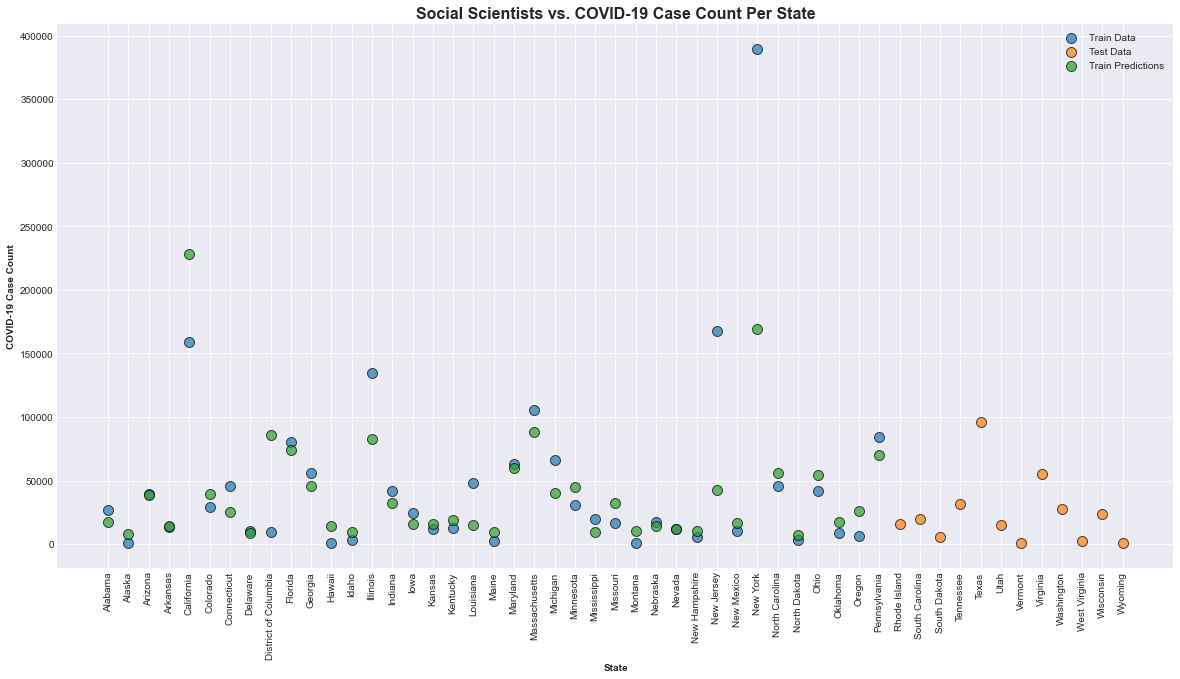

In [35]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Social Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


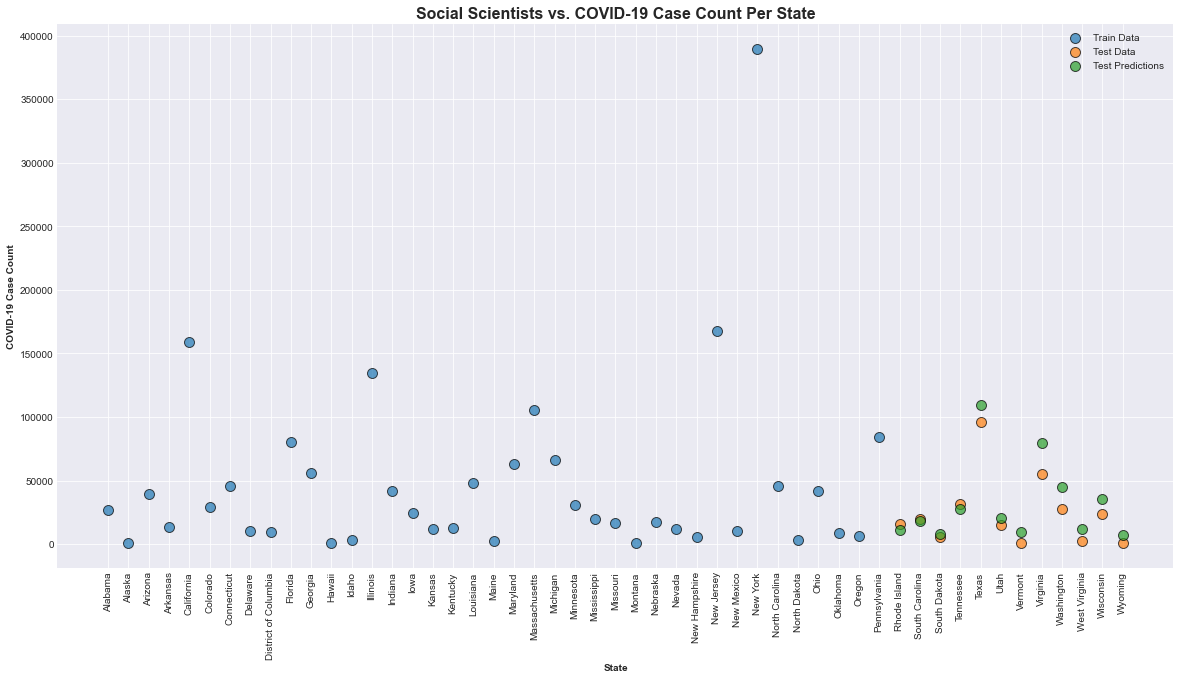

In [36]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Social Scientists vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [37]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7105 degrees.
Accuracy = 86.42%.


86.4195701210191

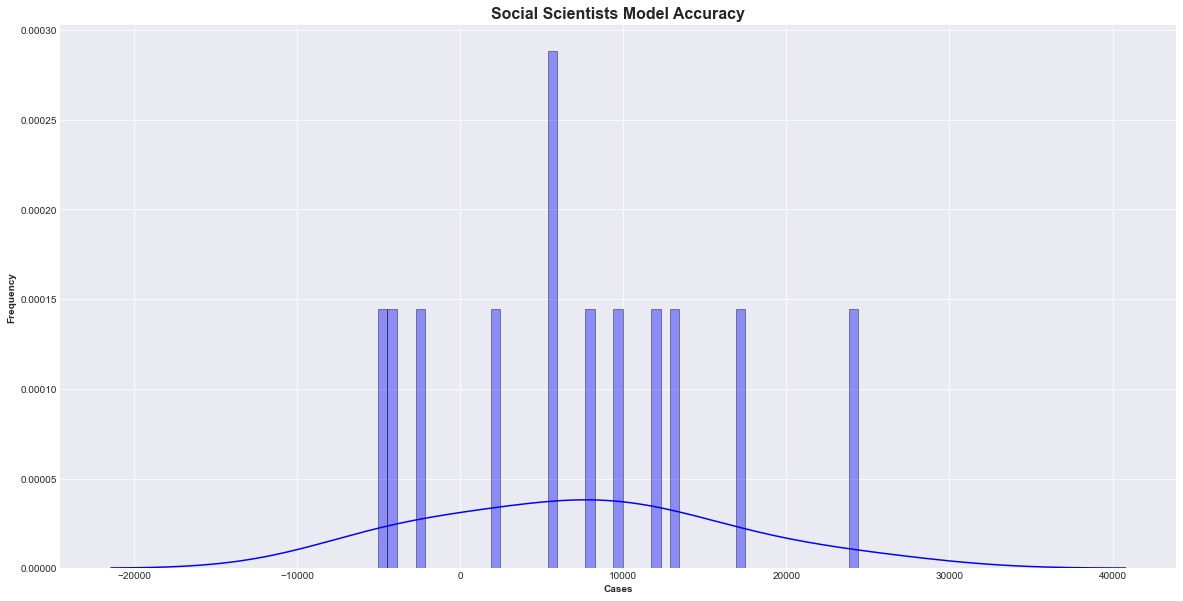

In [38]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Social Scientists Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [39]:
features_list = ['Technical Workers 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 22809.86169677057
Train MSE Value: 3022955919.3011727
Train RMS Value: 54981.414307938394
Train R2 Score: 0.3753991974327504


Test MAE Value: 11955.073929492833
Test MSE Value: 404423581.1725082
Test RMS Value: 20110.285457260627
Test R2 Score: 0.4103153537673978


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


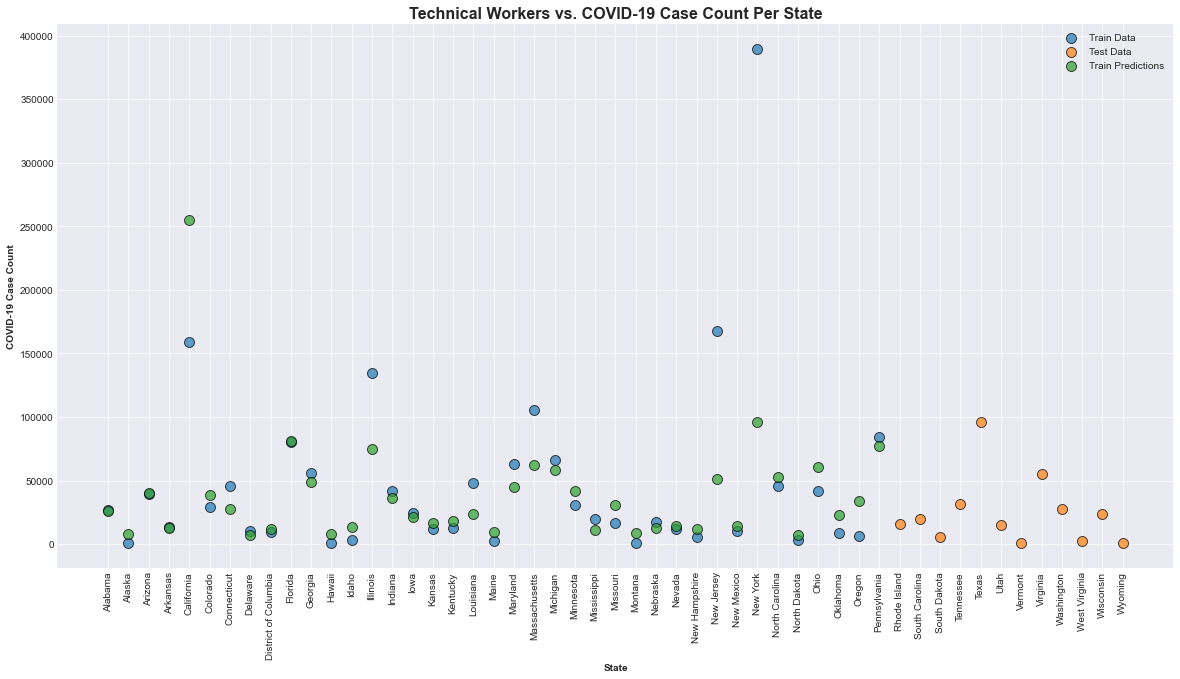

In [40]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Technical Workers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


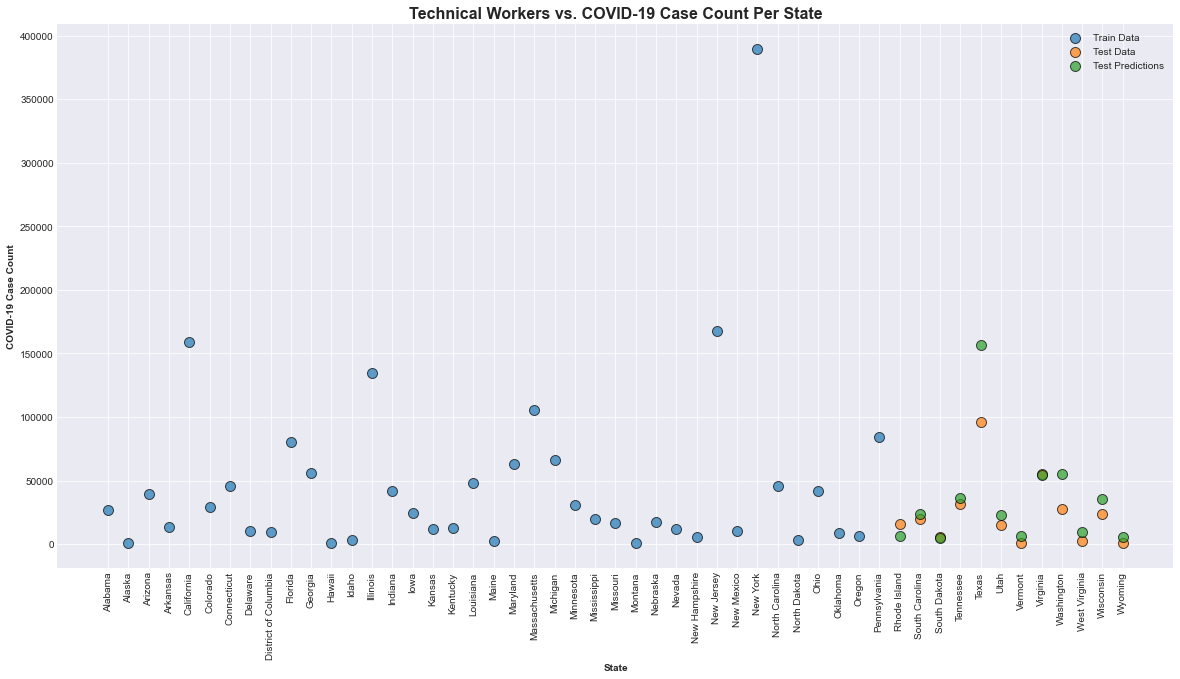

In [41]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Technical Workers vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [42]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6858 degrees.
Accuracy = 85.18%.


85.17640153065999

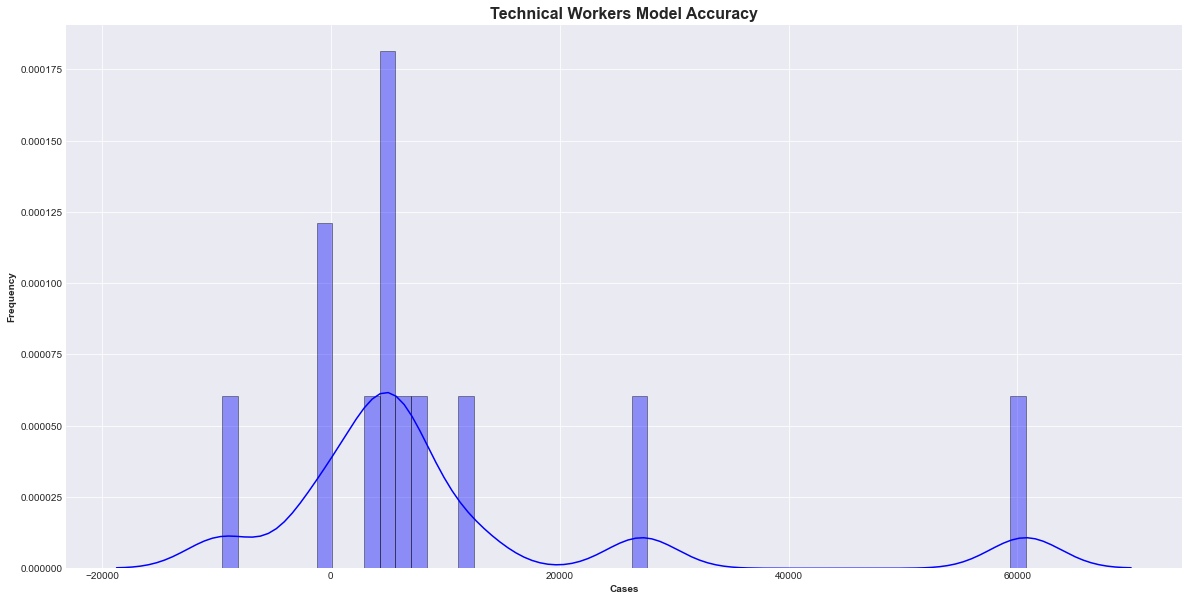

In [43]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Technical Workers Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [44]:
features_list = ['All Occupations 2018']

target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 22518.395978557703
Train MSE Value: 2865419066.6272106
Train RMS Value: 53529.60925158347
Train R2 Score: 0.40794933949265255


Test MAE Value: 8667.744066631554
Test MSE Value: 145749345.81315795
Test RMS Value: 12072.66937396854
Test R2 Score: 0.7874848168465116


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


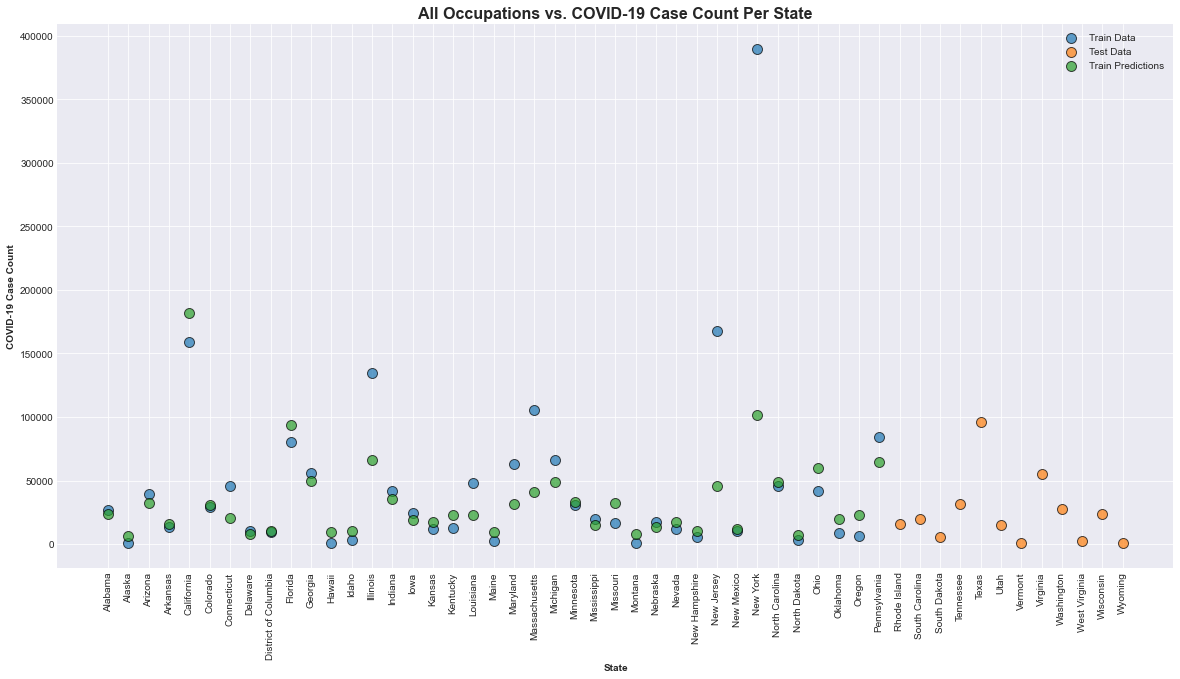

In [45]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();


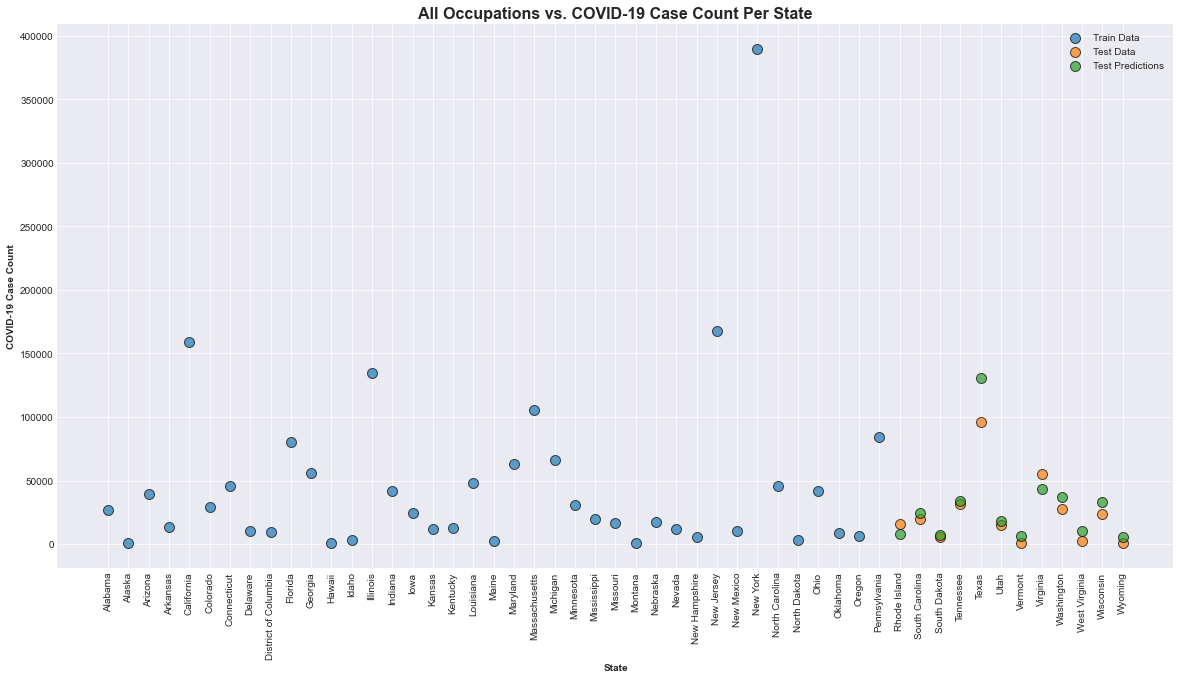

In [46]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [47]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.6507 degrees.
Accuracy = 76.01%.


76.01341276276088

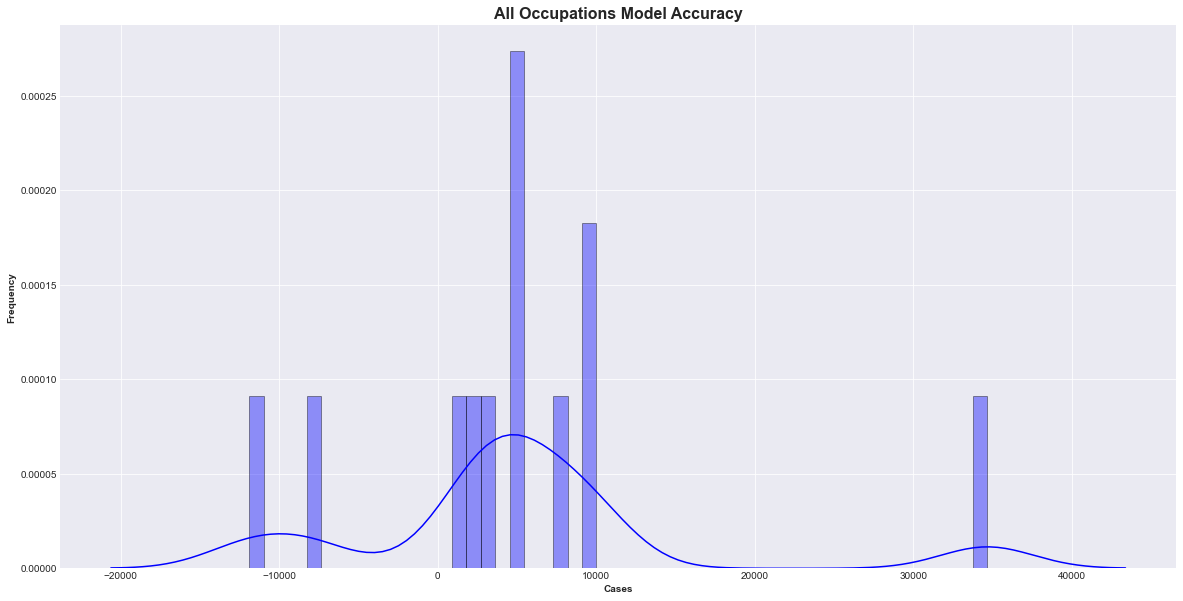

In [48]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('All Occupations Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();

In [49]:
features_list = ['Computer Mathematical Scientists 2018', 'Engineers 2018', 'Life Scientists 2018',
                 'Physical Scientists 2018', 'Science Engineer Workers 2018', 'Social Scientists 2018', 
                 'Technical Workers 2018']
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = SVRLinModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = SVRLinModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Train MAE Value: 21610.873071159887
Train MSE Value: 2043215831.0166328
Train RMS Value: 45201.94499152258
Train R2 Score: 0.5778323330079782


Test MAE Value: 10465.896078463484
Test MSE Value: 212503760.81472003
Test RMS Value: 14577.508731423213
Test R2 Score: 0.6901510919422025


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


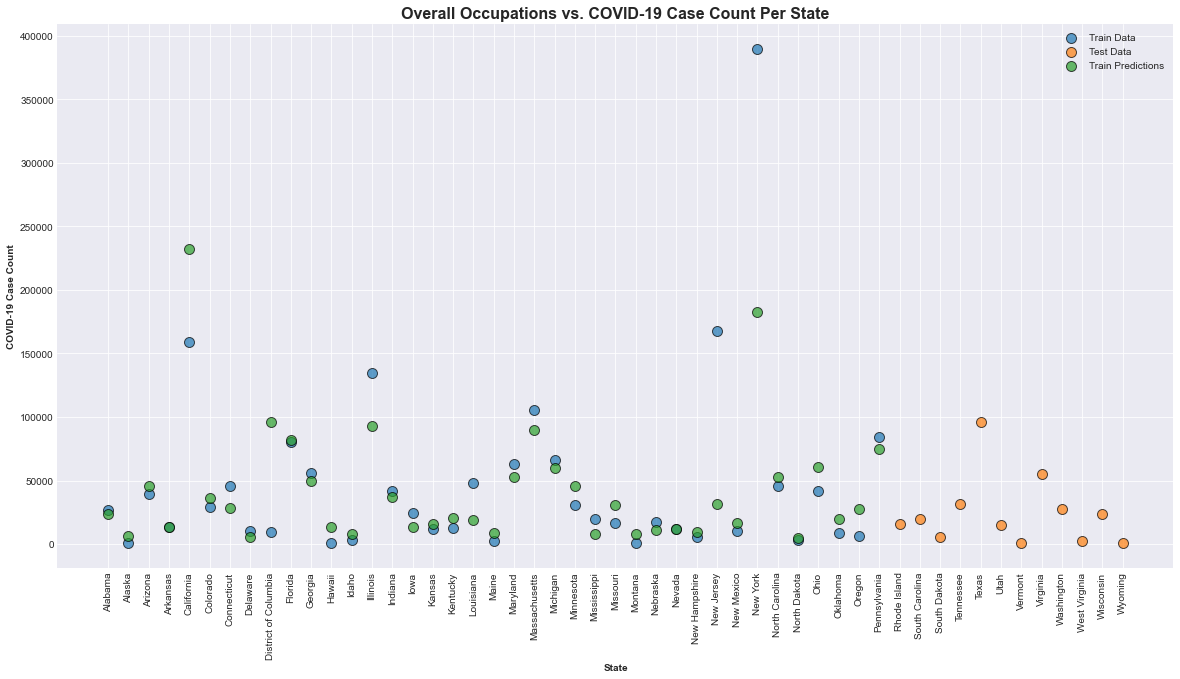

In [50]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

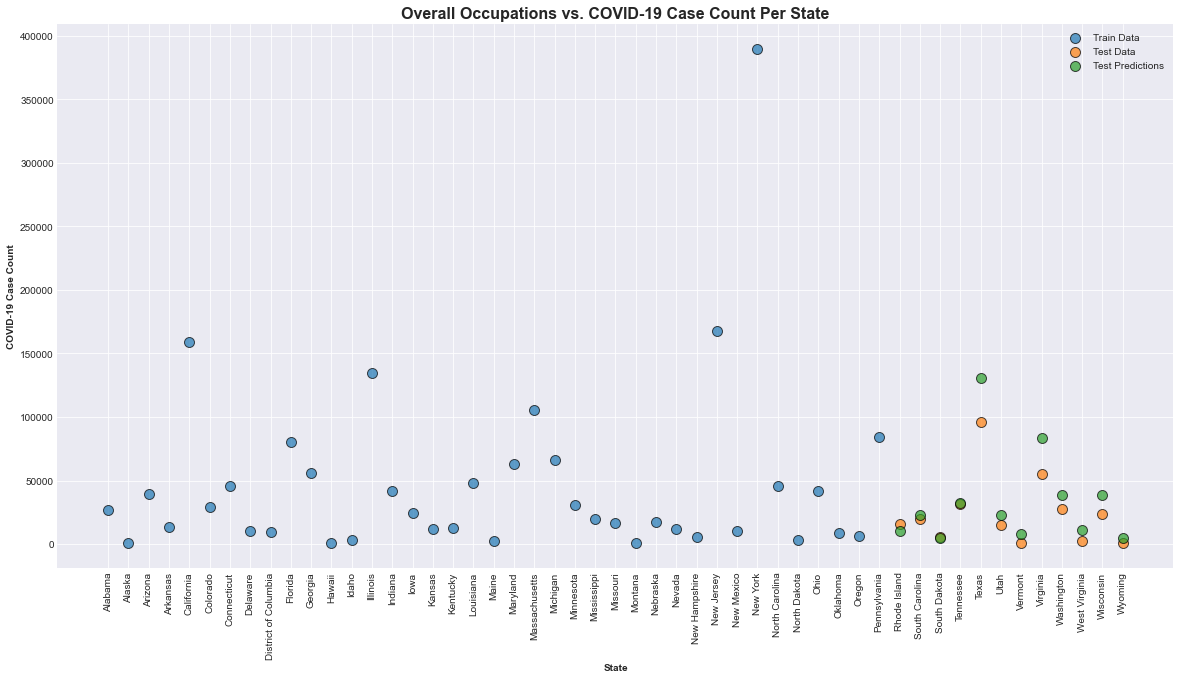

In [51]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Overall Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [52]:
evaluate(SVRLinModel, X_train_scaled, y_train_scaled)

Model Performance
Average Error: 0.7318 degrees.
Accuracy = 90.24%.


90.23917896763652

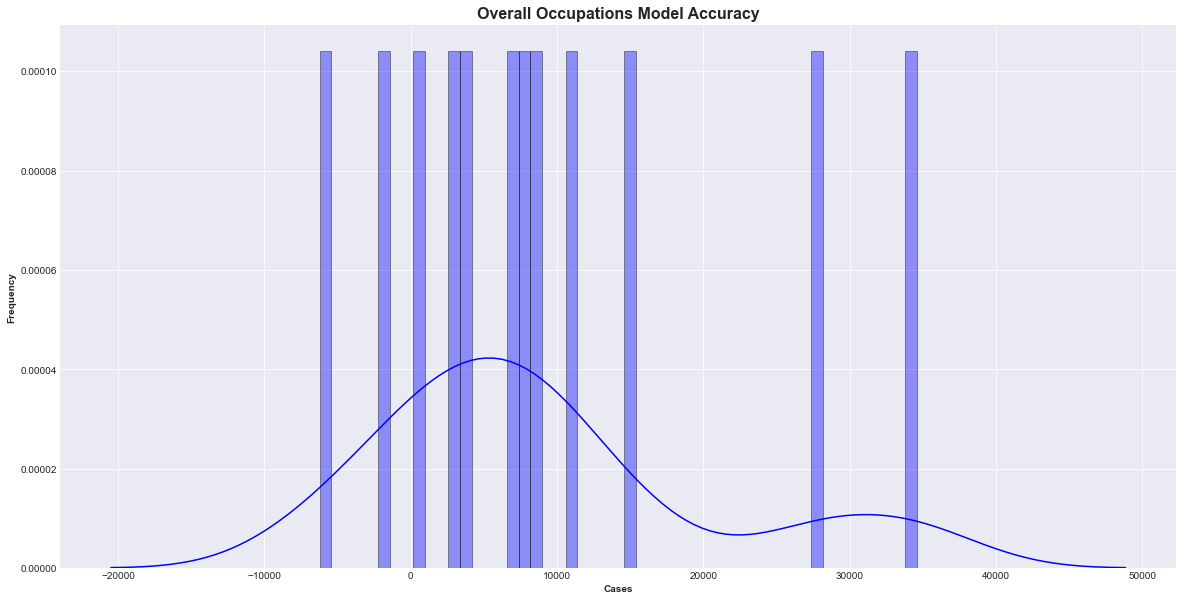

In [53]:
rcParams['figure.figsize'] = 20, 10

plt.figure()
sns.distplot((np.array(test_predictions).reshape(-1) - y_test), bins = 51, color = 'b', hist_kws = {'edgecolor':'k'})
plt.title('Overall Occupations Model Accuracy', fontsize = 16, fontweight = 'bold')
plt.xlabel('Cases', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold')

plt.show();